In [1]:
#  importing the ncecessary libraries

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import np_utils
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG19,Xception
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

2.12.0


In [2]:
#  Read the CIFAR 10 datasets from keras

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


## 1. Implement as transfer learning on the chosen dataset using Xception architecture

In [3]:
train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

print((train_images.shape, train_labels.shape))
print((test_images.shape, test_labels.shape))

((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


In [4]:
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=train_labels.shape[1])

83683744/83683744 [==============================] - 4s 0us/step


In [5]:
# freeze all layers
base_model.trainable = False

# to freeze only some of the layers
# index 0 is the input layer
#for layer in base_model.layers[:12]:
#    layer.trainable = False

In [7]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [8]:
data_augmentation = Sequential(
    [RandomFlip("horizontal"),
     RandomRotation(0.1),
     RandomZoom(0.1)]
)

In [10]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = data_augmentation(x)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(10, activation=('softmax'))(x)
model1 = tf.keras.Model(inputs, outputs)

In [11]:
#Check the architecture of the final model
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        2086

In [12]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:

history = model1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=20, verbose=1)

Epoch 1/20
1563/1563 [==============================] - 291s 179ms/step - loss: 0.7548 - accuracy: 0.7436 - val_loss: 0.4428 - val_accuracy: 0.8499
Epoch 2/20
1563/1563 [==============================] - 314s 201ms/step - loss: 0.6393 - accuracy: 0.7802 - val_loss: 0.4063 - val_accuracy: 0.8641
Epoch 3/20
1563/1563 [==============================] - 315s 202ms/step - loss: 0.6259 - accuracy: 0.7860 - val_loss: 0.4099 - val_accuracy: 0.8601
Epoch 4/20
1563/1563 [==============================] - 315s 201ms/step - loss: 0.6214 - accuracy: 0.7882 - val_loss: 0.4079 - val_accuracy: 0.8636
Epoch 5/20
1563/1563 [==============================] - 315s 201ms/step - loss: 0.6163 - accuracy: 0.7905 - val_loss: 0.3916 - val_accuracy: 0.8675
Epoch 6/20
1563/1563 [==============================] - 279s 178ms/step - loss: 0.6090 - accuracy: 0.7919 - val_loss: 0.3925 - val_accuracy: 0.8696
Epoch 7/20
1563/1563 [==============================] - 314s 201ms/step - loss: 0.6041 - accuracy: 0.7932 - val_

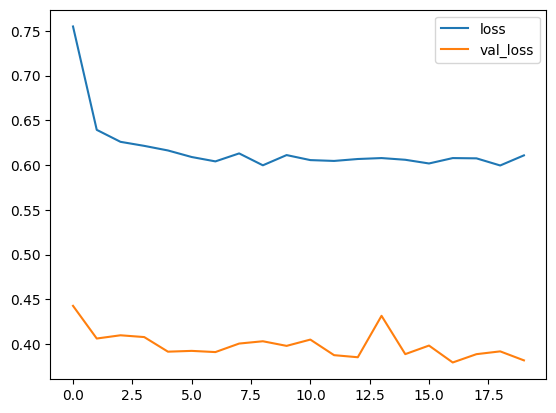

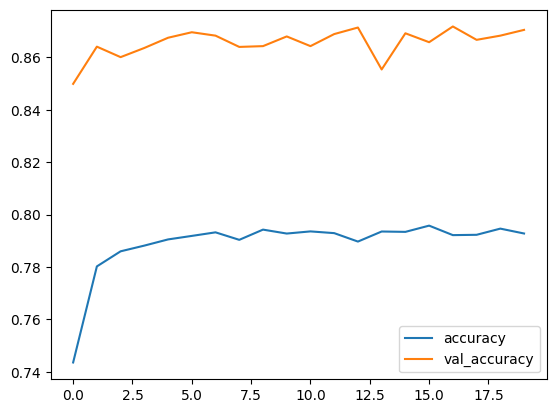

In [15]:
import pandas as pd
def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

    return

plot_history(history)

## Fine Tuning

In [16]:
# unfreeze the layers of the pre-trained model

base_model.trainable = True

In [21]:
# Use a small learning rate

model1.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, verbose=1)

Epoch 1/10
1563/1563 [==============================] - 950s 590ms/step - loss: 0.3422 - accuracy: 0.8861 - val_loss: 0.1758 - val_accuracy: 0.9415
Epoch 2/10
1563/1563 [==============================] - 915s 585ms/step - loss: 0.2286 - accuracy: 0.9223 - val_loss: 0.1458 - val_accuracy: 0.9505
Epoch 3/10
1563/1563 [==============================] - 916s 586ms/step - loss: 0.1817 - accuracy: 0.9372 - val_loss: 0.1311 - val_accuracy: 0.9545
Epoch 4/10
1563/1563 [==============================] - 915s 585ms/step - loss: 0.1478 - accuracy: 0.9492 - val_loss: 0.1216 - val_accuracy: 0.9601
Epoch 5/10
1563/1563 [==============================] - 879s 562ms/step - loss: 0.1261 - accuracy: 0.9565 - val_loss: 0.1149 - val_accuracy: 0.9655
Epoch 6/10
1563/1563 [==============================] - 913s 584ms/step - loss: 0.1094 - accuracy: 0.9623 - val_loss: 0.1115 - val_accuracy: 0.9642
Epoch 7/10
1563/1563 [==============================] - 912s 584ms/step - loss: 0.0923 - accuracy: 0.9682 - val_

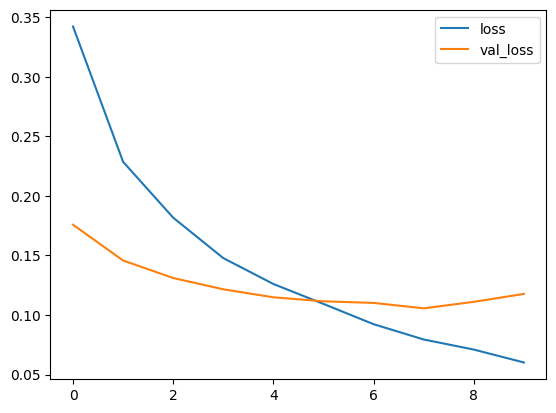

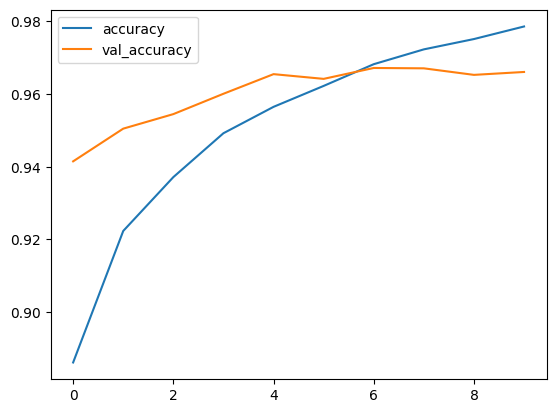

In [23]:
plot_history(history)

313/313 [==============================] - 48s 152ms/step


[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

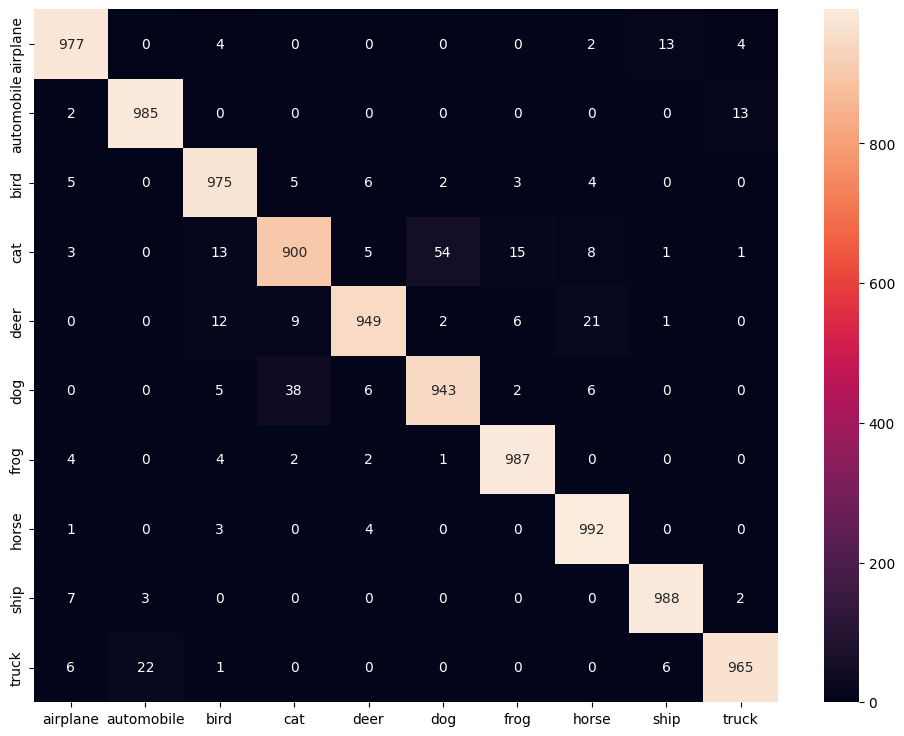

In [24]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predictions=model1.predict(test_images)

y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(test_labels, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)

##2. On the chosen dataset , using CNN for image classification

In [ ]:
#  check the number of records
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
# number of unique classes
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# create a list of all class labels

class_names = ['airplane','automobile','bird','cat','deer','dog','frog',
                'horse','ship','truck']


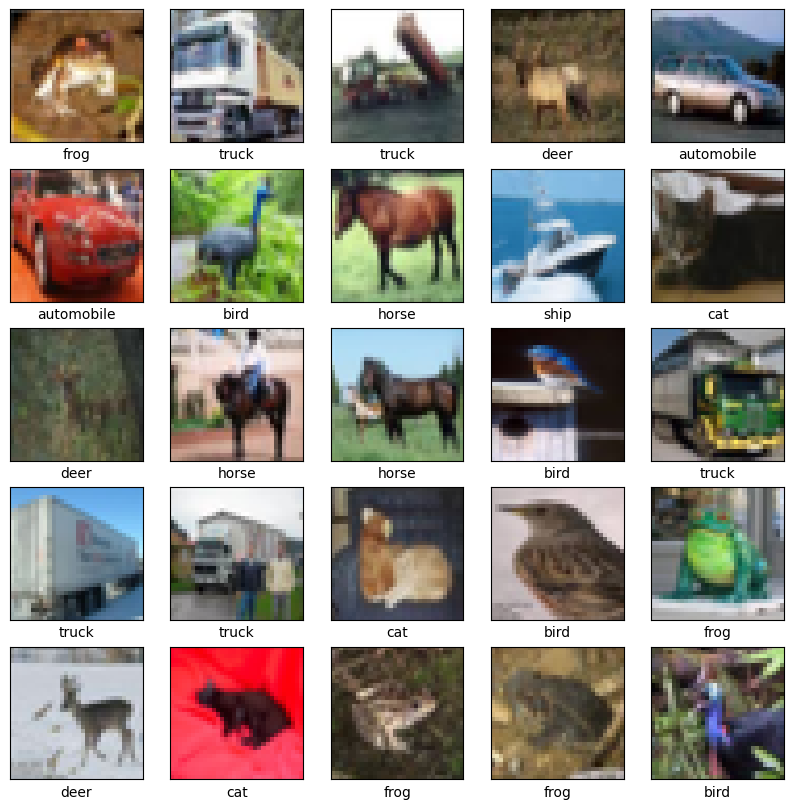

In [ ]:
# visualize the sample images from the trainning images

plt.figure(figsize= [10,10])

for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

plt.show()

In [ ]:
train_images[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [ ]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

In [ ]:
train_images[0]

array([[[ 59.,  62.,  63.],
        [ 43.,  46.,  45.],
        [ 50.,  48.,  43.],
        ...,
        [158., 132., 108.],
        [152., 125., 102.],
        [148., 124., 103.]],

       [[ 16.,  20.,  20.],
        [  0.,   0.,   0.],
        [ 18.,   8.,   0.],
        ...,
        [123.,  88.,  55.],
        [119.,  83.,  50.],
        [122.,  87.,  57.]],

       [[ 25.,  24.,  21.],
        [ 16.,   7.,   0.],
        [ 49.,  27.,   8.],
        ...,
        [118.,  84.,  50.],
        [120.,  84.,  50.],
        [109.,  73.,  42.]],

       ...,

       [[208., 170.,  96.],
        [201., 153.,  34.],
        [198., 161.,  26.],
        ...,
        [160., 133.,  70.],
        [ 56.,  31.,   7.],
        [ 53.,  34.,  20.]],

       [[180., 139.,  96.],
        [173., 123.,  42.],
        [186., 144.,  30.],
        ...,
        [184., 148.,  94.],
        [ 97.,  62.,  34.],
        [ 83.,  53.,  34.]],

       [[177., 144., 116.],
        [168., 129.,  94.],
        [179., 1

In [ ]:
# normalization
train_images = train_images/255
test_images = test_images/255

In [ ]:
# one hot encoding for the target classes
num_classes = 10

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [ ]:
train_labels[4]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#  build the CNN model

model = Sequential()
model.add(layers.Conv2D( filters = 32,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                         data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                         use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                         kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                         kernel_constraint=None, bias_constraint=None,input_shape = (32,32,3)))

model.add(layers.BatchNormalization())

model.add(layers.Conv2D(filters = 32,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                 data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                 use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                 kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size= (2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64,kernel_size = (3,3) ,strides=(1, 1),padding="same",
                 data_format=None, dilation_rate=(1, 1), groups=1, activation='relu',
                 use_bias=True, kernel_initializer="glorot_uniform",bias_initializer="zeros",
                 kernel_regularizer=None,bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None))

model.add(layers.BatchNormalization())

model.add(layers.MaxPool2D(pool_size= (2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(units = 128 ,activation='relu', use_bias=True, kernel_initializer="glorot_uniform",
                       bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None,
                       activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units = num_classes ,activation='softmax', use_bias=True, kernel_initializer="glorot_uniform",
                       bias_initializer="zeros", kernel_regularizer=None, bias_regularizer=None,
                       activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
model.compile(optimizer='adam', loss= keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size= 64, epochs= 100, validation_data= (test_images, test_labels))

Epoch 1/100
782/782 [==============================] - 21s 11ms/step - loss: 1.5382 - accuracy: 0.4713 - val_loss: 1.1862 - val_accuracy: 0.5848
Epoch 2/100
782/782 [==============================] - 8s 10ms/step - loss: 1.0943 - accuracy: 0.6159 - val_loss: 1.0735 - val_accuracy: 0.6201
Epoch 3/100
782/782 [==============================] - 8s 10ms/step - loss: 0.9633 - accuracy: 0.6641 - val_loss: 0.9470 - val_accuracy: 0.6681
Epoch 4/100
782/782 [==============================] - 8s 10ms/step - loss: 0.8939 - accuracy: 0.6870 - val_loss: 0.8620 - val_accuracy: 0.7067
Epoch 5/100
782/782 [==============================] - 8s 10ms/step - loss: 0.8416 - accuracy: 0.7058 - val_loss: 1.1045 - val_accuracy: 0.6479
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.8034 - accuracy: 0.7183 - val_loss: 0.7911 - val_accuracy: 0.7279
Epoch 7/100
782/782 [==============================] - 9s 11ms/step - loss: 0.7704 - accuracy: 0.7314 - val_loss: 0.7826 - val_accuracy

Text(0.5, 1.0, 'Loss Curves')

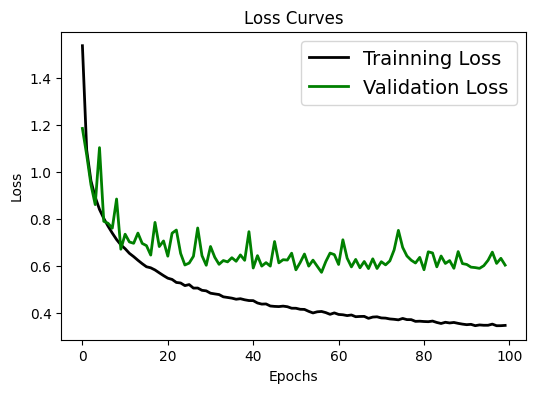

In [ ]:
# loss curve

plt.figure(figsize= [6,4])
plt.plot(history.history['loss'], 'black', linewidth = 2.0)
plt.plot(history.history['val_loss'], 'green', linewidth = 2.0)
plt.legend(['Trainning Loss', 'Validation Loss'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.title('Loss Curves', fontsize = 12)

Text(0.5, 1.0, 'Accuracy Curves')

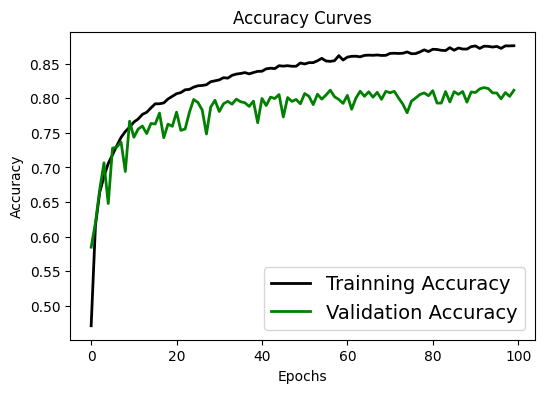

In [ ]:
# Accuracy curve

plt.figure(figsize= [6,4])
plt.plot(history.history['accuracy'], 'black', linewidth = 2.0)
plt.plot(history.history['val_accuracy'], 'green', linewidth = 2.0)
plt.legend(['Trainning Accuracy', 'Validation Accuracy'], fontsize = 14)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.title('Accuracy Curves', fontsize = 12)